## Задание
Разобраться с моделькой перевода как она устроена
запустить для перевода с русского на английский (при желании можно взять другие пары языков) два варианта с вниманием и без внимания
оценить качество насколько корректно переводит (для теста отобрать примеры с увеличением длины текста) (так как оценка визуальная достаточно 20-ти примеров в тестовой выборке)

#### 1. Начнем с модели без внимания

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/

In [ ]:
!wget http://www.manythings.org/anki/rus-eng.zip

--2022-07-19 04:00:38--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14819554 (14M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  14.13M  28.8MB/s    in 0.5s    

2022-07-19 04:00:39 (28.8 MB/s) - ‘rus-eng.zip’ saved [14819554/14819554]



In [ ]:
!mkdir rus-eng
!unzip rus-eng.zip -d rus-eng/

Archive:  rus-eng.zip
  inflating: rus-eng/rus.txt         
  inflating: rus-eng/_about.txt      


In [ ]:
!ls /content/rus-eng/ -lah

total 71M
drwxr-xr-x 2 root root 4.0K Jul 19 04:00 .
drwxr-xr-x 1 root root 4.0K Jul 19 04:00 ..
-rw-r--r-- 1 root root 1.5K May  2 01:29 _about.txt
-rw-r--r-- 1 root root  71M May  2 01:29 rus.txt


In [ ]:
# Path to the file
path_to_file = "/content/rus-eng/rus.txt"

Функция препроцессинга текста, в т.ч. ставим токены start end

In [ ]:
def preprocess_sentence(w):
  w = w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

Функция для создания пар русский-английский, которые потребуются для обучения и валидации

In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENG, RUS]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

  return zip(*word_pairs)

Пример, как будут выглядеть данные на русском и английском

In [ ]:
en, ru = create_dataset(path_to_file, None)
print(en[0])
print(ru[0])

<start> go . <end>
<start> марш ! <end>


Функция токенизации, возвращает последовательность токенов с паддингом и сам токенайзер

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

Создаем функцию, которая вернет входной и таргет тензоры для последовательностей и токенайзеры инпута и таргета

In [ ]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)

In [ ]:
len(en), len(ru)

(444587, 444587)

Для более быстрого процесса обучения ограничим количество примеров до 100 000

In [ ]:
# Try experimenting with the size of that dataset
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

Разобьем данные на train и test

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


### Create a tf.data dataset

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 300
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

Создаем классы энкодера и декодера

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=False,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

  def call(self, x, hidden):
    # enc_output shape == (batch_size, max_length, hidden_size)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x, initial_state=hidden)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

## Define the optimizer and the loss function

In [ ]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [ ]:
checkpoint_dir = './training_nmt_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden = decoder(dec_input, dec_hidden)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.7408
Epoch 1 Batch 100 Loss 2.0539
Epoch 1 Batch 200 Loss 1.8918
Epoch 1 Batch 300 Loss 1.5905
Epoch 1 Batch 400 Loss 1.6201
Epoch 1 Batch 500 Loss 1.4649
Epoch 1 Batch 600 Loss 1.3822
Epoch 1 Batch 700 Loss 1.2878
Epoch 1 Batch 800 Loss 1.1977
Epoch 1 Batch 900 Loss 1.1513
Epoch 1 Batch 1000 Loss 1.1360
Epoch 1 Batch 1100 Loss 1.0979
Epoch 1 Batch 1200 Loss 1.0953
Epoch 1 Loss 1.4726
Time taken for 1 epoch 71.47051119804382 sec

Epoch 2 Batch 0 Loss 0.9283
Epoch 2 Batch 100 Loss 0.9269
Epoch 2 Batch 200 Loss 0.7939
Epoch 2 Batch 300 Loss 0.8200
Epoch 2 Batch 400 Loss 0.8750
Epoch 2 Batch 500 Loss 0.7504
Epoch 2 Batch 600 Loss 0.8472
Epoch 2 Batch 700 Loss 0.6905
Epoch 2 Batch 800 Loss 0.7866
Epoch 2 Batch 900 Loss 0.6720
Epoch 2 Batch 1000 Loss 0.7731
Epoch 2 Batch 1100 Loss 0.7924
Epoch 2 Batch 1200 Loss 0.5250
Epoch 2 Loss 0.7595
Time taken for 1 epoch 58.21958875656128 sec

Epoch 3 Batch 0 Loss 0.3982
Epoch 3 Batch 100 Loss 0.4136
Epoch 3 Batch 200 Loss 0.388

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden = decoder(dec_input, dec_hidden)

    # storing the attention weights to plot later on
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence

In [ ]:
def translate(sentence):
  result, sentence = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

## Restore the latest checkpoint and test

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Посмотрим, как модель переводит

In [ ]:
translate('Привет, как дела?')

Input: <start> привет , как дела ? <end>
Predicted translation: hi . how are you ? <end> 


In [ ]:
translate('Отличная погода')

Input: <start> отличная погода <end>
Predicted translation: this is a nice person . <end> 


In [ ]:
translate('Карта мира')

Input: <start> карта мира <end>
Predicted translation: the beer is attentive . <end> 


In [ ]:
translate('Чем я могу помочь?')

Input: <start> чем я могу помочь ? <end>
Predicted translation: how can i be of help ? <end> 


In [ ]:
translate('Сколько сейчас времени?')

Input: <start> сколько сейчас времени ? <end>
Predicted translation: what time is it now ? <end> 


In [ ]:
translate('Сегодня на улице отличная погода')

Input: <start> сегодня на улице отличная погода <end>
Predicted translation: today is a big mistake . <end> 


In [ ]:
translate('Сколько времени нужно, чтобы добраться до остановки')

Input: <start> сколько времени нужно , чтобы добраться до остановки <end>
Predicted translation: how old or i contact ? <end> 


In [ ]:
translate('Банк выпустил новую карту')

Input: <start> банк выпустил новую карту <end>
Predicted translation: the book was new . <end> 


In [ ]:
translate('Прогулка была приятной')

Input: <start> прогулка была приятной <end>
Predicted translation: a little sweet . <end> 


In [ ]:
translate('На море волны')

Input: <start> на море волны <end>
Predicted translation: the well is dry . <end> 


In [ ]:
translate('Как тебя зовут?')

Input: <start> как тебя зовут ? <end>
Predicted translation: what's your name ? <end> 


In [ ]:
translate('Я прошел урок по математике')

Input: <start> я прошел урок по математике <end>
Predicted translation: was i to rich ? <end> 


In [ ]:
translate('Что такое корабль?')

Input: <start> что такое корабль ? <end>
Predicted translation: what is bullfighting ? <end> 


In [ ]:
translate('Быть или не быть вот в чем вопрос?')

Input: <start> быть или не быть вот в чем вопрос ? <end>
Predicted translation: what should we go ? <end> 


In [ ]:
translate('Горе от ума')

Input: <start> горе от ума <end>
Predicted translation: is the nuts are allowed . <end> 


## Теперь обучим модель со слоем внимания

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

Класс для слоя Внимания

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)

В декодере добавился слой внимания

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './training_attention_checkpoints_2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

Функция обучения

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.7032
Epoch 1 Batch 100 Loss 2.2169
Epoch 1 Batch 200 Loss 1.8190
Epoch 1 Batch 300 Loss 1.6080
Epoch 1 Batch 400 Loss 1.5772
Epoch 1 Batch 500 Loss 1.4872
Epoch 1 Batch 600 Loss 1.3143
Epoch 1 Batch 700 Loss 1.3198
Epoch 1 Batch 800 Loss 1.2200
Epoch 1 Batch 900 Loss 1.1137
Epoch 1 Batch 1000 Loss 1.0883
Epoch 1 Batch 1100 Loss 1.1568
Epoch 1 Batch 1200 Loss 0.9867
Epoch 1 Loss 1.4447
Time taken for 1 epoch 112.38990616798401 sec

Epoch 2 Batch 0 Loss 0.7876
Epoch 2 Batch 100 Loss 0.8407
Epoch 2 Batch 200 Loss 0.7857
Epoch 2 Batch 300 Loss 0.7887
Epoch 2 Batch 400 Loss 0.6930
Epoch 2 Batch 500 Loss 0.6160
Epoch 2 Batch 600 Loss 0.5875
Epoch 2 Batch 700 Loss 0.6106
Epoch 2 Batch 800 Loss 0.5215
Epoch 2 Batch 900 Loss 0.5680
Epoch 2 Batch 1000 Loss 0.5844
Epoch 2 Batch 1100 Loss 0.4897
Epoch 2 Batch 1200 Loss 0.5902
Epoch 2 Loss 0.6685
Time taken for 1 epoch 102.18650555610657 sec

Epoch 3 Batch 0 Loss 0.3309
Epoch 3 Batch 100 Loss 0.3005
Epoch 3 Batch 200 Loss 0.4

Функция для запуска перевода

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

Функци, визуализирующая связь исходной последовательности и перевода

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

Функция, объединяющая две предыдущие функции

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Посмотрим на качество перевода

Input: <start> привет , как дела ? <end>
Predicted translation: hi ! how are you ? <end> 


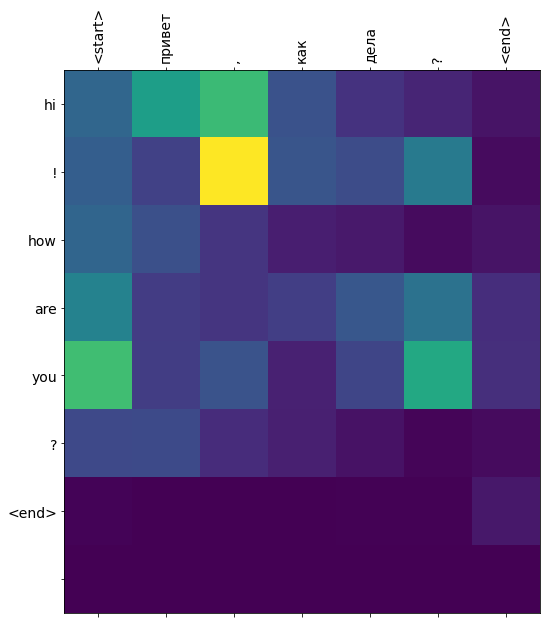

In [ ]:
translate('Привет, как дела?')

Input: <start> отличная погода <end>
Predicted translation: it's rather good . <end> 


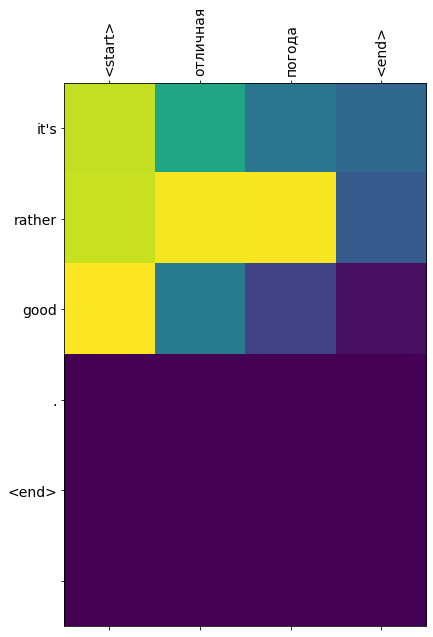

In [ ]:
translate('Отличная погода')

Input: <start> карта мира <end>
Predicted translation: the bag turned on high . <end> 


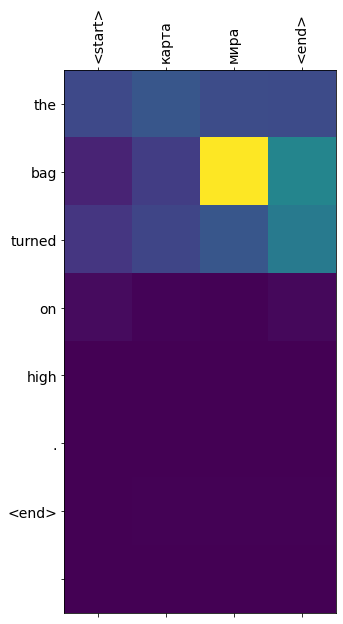

In [ ]:
translate('Карта мира')

Input: <start> чем я могу помочь ? <end>
Predicted translation: how can i help ? <end> 


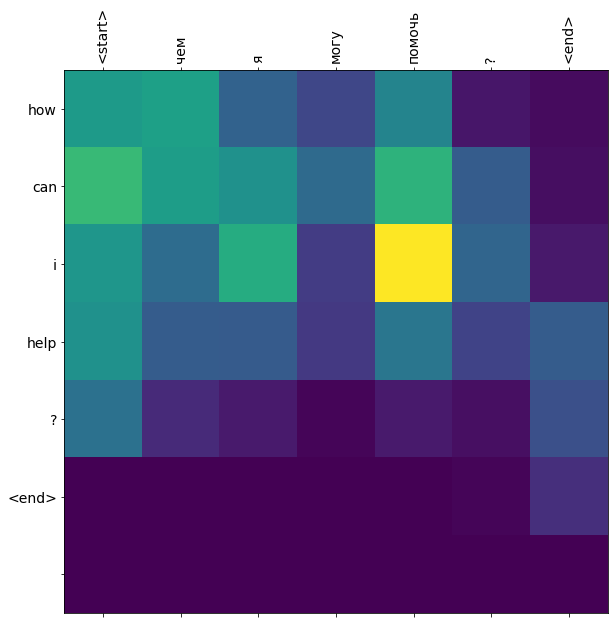

In [ ]:
translate('Чем я могу помочь?')

Input: <start> сколько сейчас времени ? <end>
Predicted translation: what time is it now ? <end> 


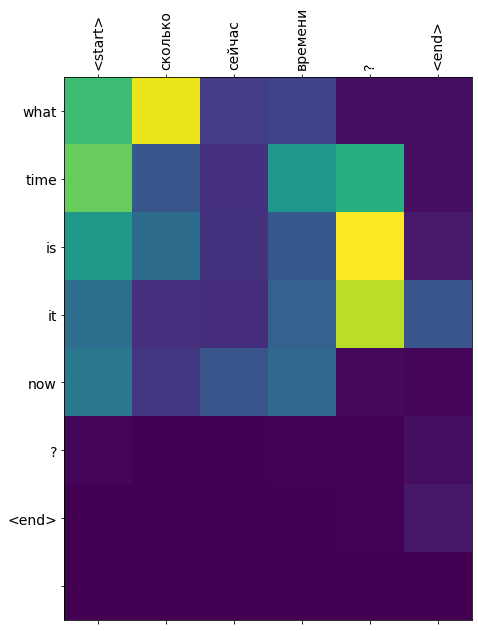

In [ ]:
translate('Сколько сейчас времени?')

Input: <start> сегодня на улице отличная погода <end>
Predicted translation: it's all right out . <end> 


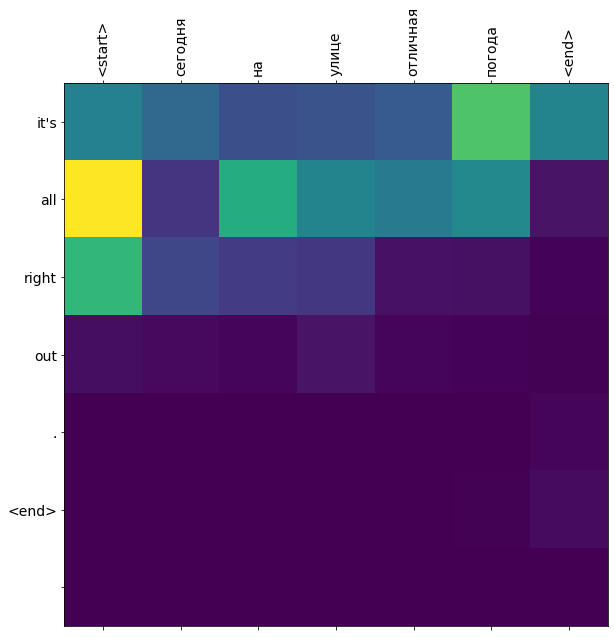

In [ ]:
translate('Сегодня на улице отличная погода')

Input: <start> сколько времени нужно , чтобы добраться до остановки <end>
Predicted translation: large while i rain . <end> 


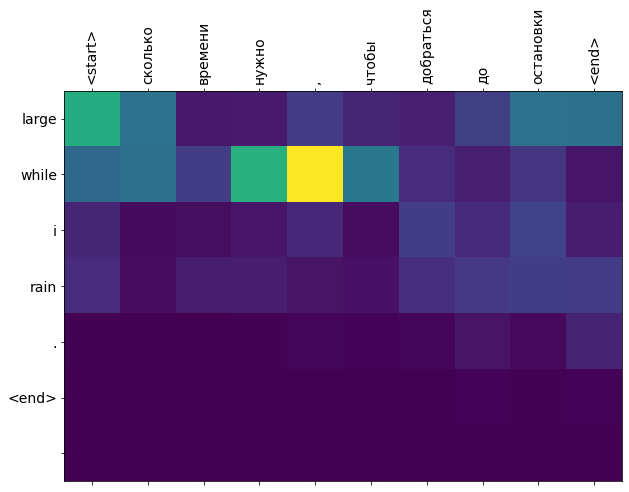

In [ ]:
translate('Сколько времени нужно, чтобы добраться до остановки')

Input: <start> банк выпустил новую карту <end>
Predicted translation: the plane is fast . <end> 


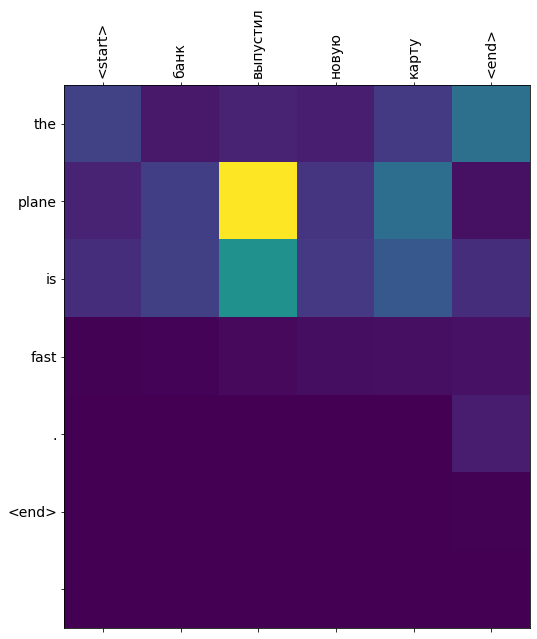

In [ ]:
translate('Банк выпустил новую карту')

Input: <start> прогулка была приятной <end>
Predicted translation: last way was nice . <end> 


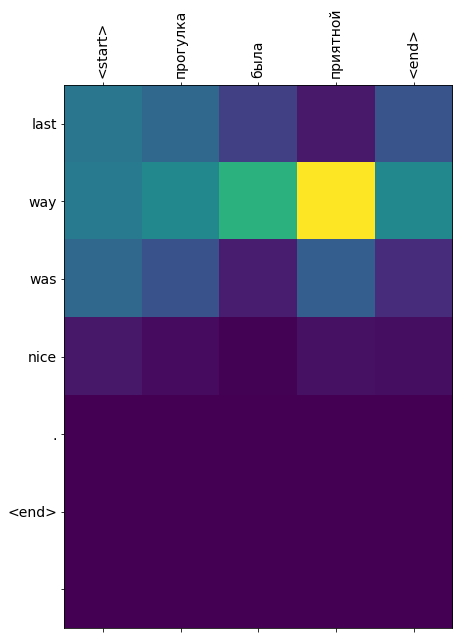

In [ ]:
translate('Прогулка была приятной')

Input: <start> на море волны <end>
Predicted translation: the boy is lonely . <end> 


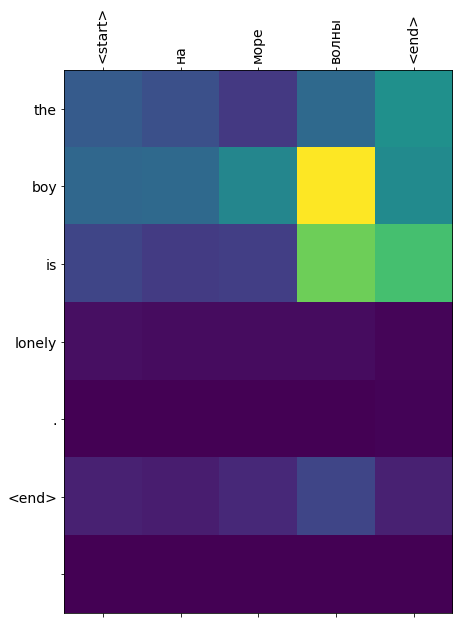

In [ ]:
translate('На море волны')

Input: <start> как тебя зовут ? <end>
Predicted translation: what is your name ? <end> 


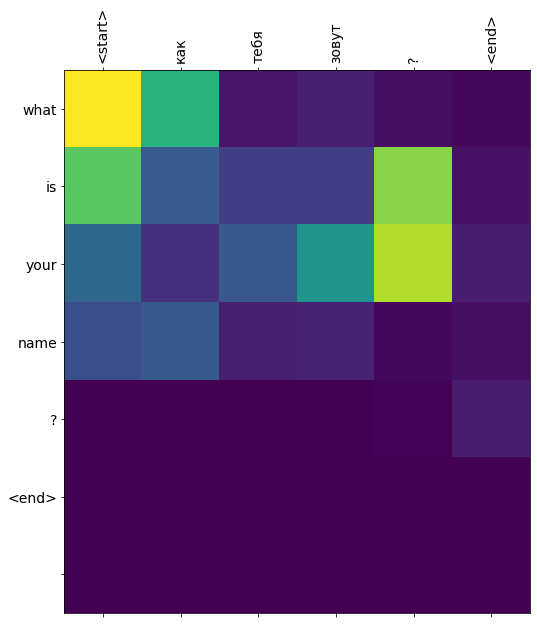

In [ ]:
translate('Как тебя зовут?')

Input: <start> я прошел урок по математике <end>
Predicted translation: i hear i agree . <end> 


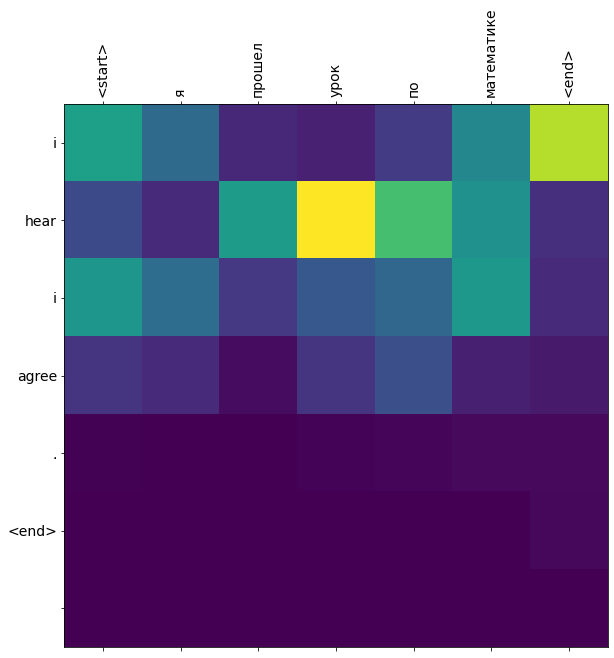

In [ ]:
translate('Я прошел урок по математике')

Input: <start> что такое корабль ? <end>
Predicted translation: what is the flight ? <end> 


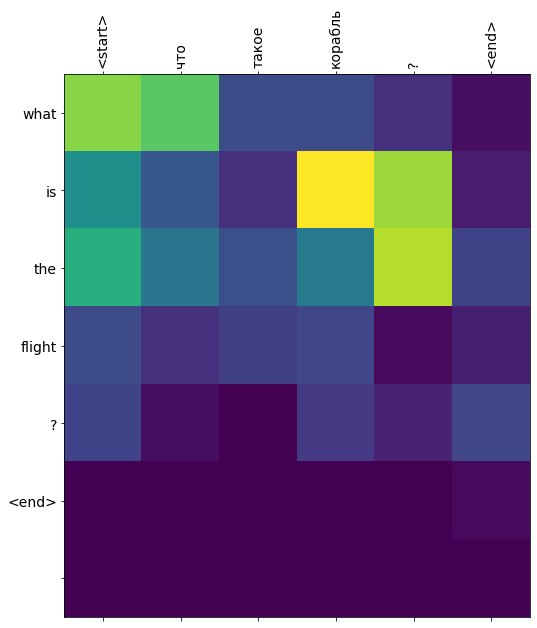

In [ ]:
translate('Что такое корабль?')

Input: <start> быть или не быть вот в чем вопрос ? <end>
Predicted translation: it's not the same or a same or a same or 


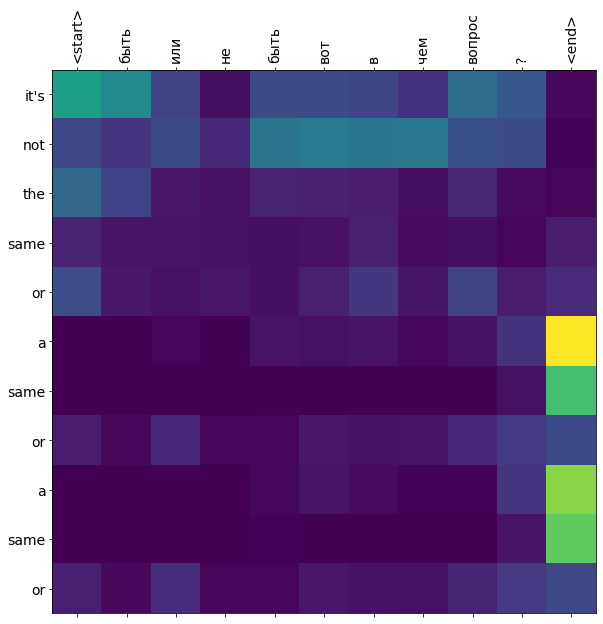

In [ ]:
translate('Быть или не быть вот в чем вопрос?')

Input: <start> горе от ума <end>
Predicted translation: mom is crazy ! <end> 


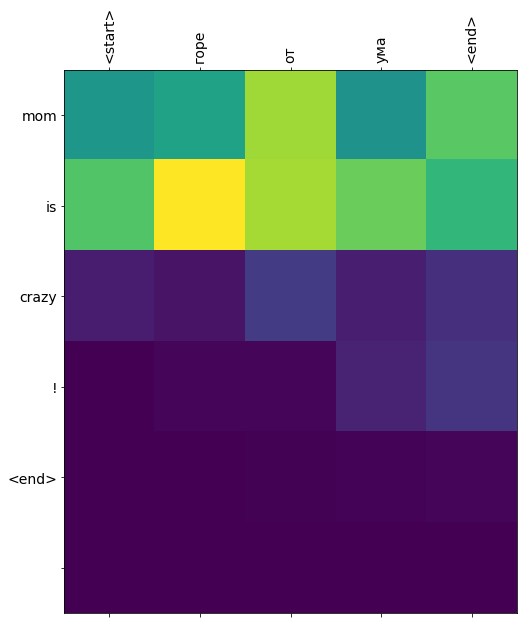

In [ ]:
translate('Горе от ума')

Вывод: в рамках данной задачи сложно сказать, что слой внимания сильно улучшил качество перевода, может быть чуть-чуть